## PyTorch Tutorial

IFT6135 – Representation Learning

A Deep Learning Course, January 2020

By Chin-Wei Huang 

(Adapted from Sandeep Subramanian's MILA tutorial)

### Torch Autograd, Define-by-run & Execution Paradigm

Adapted from
1. http://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py 
2. http://pytorch.org/docs/master/notes/autograd.html

## Variables : Thin wrappers around tensors to facilitate autograd

Supports almost all operations that can be performed on regular tensors

In [0]:
import numpy as np
import torch 

### Properties of Tensor : Requiring gradients, Data & Grad

1. You can access the raw tensor through the .data attribute
2. Gradient of the loss w.r.t. this variable is accumulated into .grad.
3. Stay tuned for requires_grad

In [2]:
z = torch.Tensor(5, 3).uniform_(-1, 1)

print(z.data)
print('Gradient : %s ' % (z.grad))
print('Requires Gradient : %s ' % (z.requires_grad))
print('Requires Gradient : %s ' % (z.requires_grad_().requires_grad))

tensor([[ 0.4394, -0.1984,  0.9558],
        [ 0.7402, -0.1596, -0.0434],
        [-0.6773, -0.7107,  0.9269],
        [ 0.4786, -0.1481, -0.6708],
        [ 0.2807,  0.9385,  0.6715]])
Gradient : None 
Requires Gradient : False 
Requires Gradient : True 


## Define-by-run Paradigm

The torch autograd package provides automatic differentiation for all operations on Tensors.

PyTorch's autograd is a reverse mode automatic differentiation system.

Backprop is defined by how your code is run, and that every single iteration can be different.

Other frameworks that adopt a similar approach :

1. Chainer - https://github.com/chainer/chainer
2. DyNet - https://github.com/clab/dynet
3. Tensorflow Eager - https://research.googleblog.com/2017/10/eager-execution-imperative-define-by.html

### How autograd encodes execution history


Conceptually, autograd maintains a graph that records all of the operations performed on variables as you execute your operations. This results in a directed acyclic graph whose leaves are the input variables and roots are the output variables. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

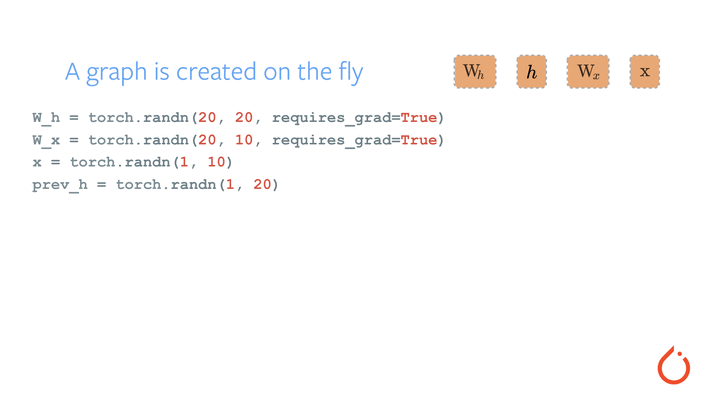


GIF source: https://github.com/pytorch/pytorch

Internally, autograd represents this graph as a graph of Function objects (really expressions), which can be `apply()` ed to compute the result of evaluating the graph. When computing the forward pass, autograd simultaneously performs the requested computations and builds up a graph representing the function that computes the gradient (the `.grad_fn` attribute of each Variable is an entry point into this graph). When the forward pass is completed, we evaluate this graph in the backwards pass to compute the gradients.

In [11]:
x = torch.Tensor(5, 3).uniform_(-1, 1)#.requires_grad_()
y = torch.Tensor(3, 5).uniform_(-1, 1)
z = torch.mm(x, y)
print(z.shape)
print(z.grad_fn)

torch.Size([5, 5])
None


An important thing to note is that the graph is recreated from scratch at every iteration, and this is exactly what allows for using arbitrary Python control flow statements, that can change the overall shape and size of the graph at every iteration. You don’t have to encode all possible paths before you launch the training - what you run is what you differentiate.

## Getting gradients : `backward()` & `torch.autograd.grad`

In [21]:
x = torch.Tensor(5, 3).uniform_(-1, 1).requires_grad_()
y = torch.Tensor(5, 3).uniform_(-1, 1).requires_grad_()
z = x ** 2 + 3 * y
print(z.grad_fn)

In [22]:
# equivalently, z.backward(gradient=torch.ones(5, 3))
z.sum().backward()
print(x.grad)

tensor([[-0.5907, -1.4428,  1.4921],
        [ 0.7937,  1.3589,  1.4167],
        [ 0.1667,  1.2185, -0.8759],
        [-1.1303,  0.0156,  0.4777],
        [-0.1733, -1.4850,  0.1901]])


In [23]:
# eq computes element-wise equality
torch.eq(x.grad, 2 * x)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])

In [24]:
y.grad

tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])

In [31]:
x = torch.Tensor(5, 3).uniform_(-1, 1).requires_grad_()
y = torch.Tensor(5, 3).uniform_(-1, 1).requires_grad_()
z = x ** 2 + 3 * y
dz_dx = torch.autograd.grad(z, x, grad_outputs=torch.ones(5, 3))
dz_dy = torch.autograd.grad(z, y, grad_outputs=torch.ones(5, 3) * 0.5)
print(dz_dy)

(tensor([[1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000]]),)


## Define-by-run example

### Common Variable definition

In [0]:
x = torch.Tensor(5, 3).uniform_(-1, 1).requires_grad_()
w = torch.Tensor(3, 10).uniform_(-1, 1).requires_grad_()
b = torch.Tensor(10,).uniform_(-1, 1).requires_grad_()

### Graph 1 : `wx + b`

In [0]:
o = torch.matmul(x, w) + b
do_dinputs_1 = torch.autograd.grad(o, [x, w, b], grad_outputs=torch.ones(5, 10))

In [37]:
print('Gradients of o w.r.t inputs in Graph 1')
print('do/dx : \n\n %s ' % (do_dinputs_1[0]))
print('do/dw : \n\n %s ' % (do_dinputs_1[1]))
print('do/db : \n\n %s ' % (do_dinputs_1[2]))

# # equal to below
# print()
# print(w.sum(1))
# print(x.sum(0))

Gradients of o w.r.t inputs in Graph 1
do/dx : 

 tensor([[ 2.0435,  1.4538, -1.0182],
        [ 2.0435,  1.4538, -1.0182],
        [ 2.0435,  1.4538, -1.0182],
        [ 2.0435,  1.4538, -1.0182],
        [ 2.0435,  1.4538, -1.0182]]) 
do/dw : 

 tensor([[1.4681, 1.4681, 1.4681, 1.4681, 1.4681, 1.4681, 1.4681, 1.4681, 1.4681,
         1.4681],
        [0.7529, 0.7529, 0.7529, 0.7529, 0.7529, 0.7529, 0.7529, 0.7529, 0.7529,
         0.7529],
        [0.3192, 0.3192, 0.3192, 0.3192, 0.3192, 0.3192, 0.3192, 0.3192, 0.3192,
         0.3192]]) 
do/db : 

 tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]) 

tensor([ 2.0435,  1.4538, -1.0182], grad_fn=<SumBackward1>)
tensor([1.4681, 0.7529, 0.3192], grad_fn=<SumBackward1>)


### Graph 2 : wx / b

In [0]:
o = torch.matmul(x, w) / b
do_dinputs_2 = torch.autograd.grad(o, [x, w, b], grad_outputs=torch.ones(5, 10))

In [43]:
print('Gradients of o w.r.t inputs in Graph 2')
print('do/dx : \n %s ' % (do_dinputs_2[0]))
print('do/dw : \n %s ' % (do_dinputs_2[1]))
print('do/db : \n %s ' % (do_dinputs_2[2]))

# # equal to below
# print()
# print((w/b[None,:]).sum(1))
# print((x.sum(0)[:,None]/b[None,:]))

Gradients of o w.r.t inputs in Graph 2
do/dx : 
 tensor([[ -0.8414, -43.3441, -47.0622],
        [ -0.8414, -43.3441, -47.0622],
        [ -0.8414, -43.3441, -47.0622],
        [ -0.8414, -43.3441, -47.0622],
        [ -0.8414, -43.3441, -47.0622]]) 
do/dw : 
 tensor([[-23.2437,   2.5189,  -1.5161,  -3.5018,   1.5028,  -4.9672,  87.1287,
          -1.8984,  -4.5722,  -1.4907],
        [-11.9200,   1.2917,  -0.7775,  -1.7958,   0.7707,  -2.5473,  44.6819,
          -0.9736,  -2.3447,  -0.7644],
        [ -5.0542,   0.5477,  -0.3297,  -0.7614,   0.3268,  -1.0801,  18.9455,
          -0.4128,  -0.9942,  -0.3241]]) 
do/db : 
 tensor([-1.3861e+02, -2.9171e+00,  1.0289e+00, -8.0308e+00,  1.1689e-01,
        -8.4484e+00,  2.1366e+03, -2.4792e+00,  6.2121e+00, -9.4532e-01]) 


## Gradient buffers: `.backward()` and `retain_graph=True`

1. Calling `.backward()` clears the current computation graph.
2. Once `.backward()` is called, intermediate variables used in the construction of the graph are removed.
2. This is used implicitly to let PyTorch know when a new graph is to be built for a new minibatch. This is built around the forward and backward pass paradigm.
3. To retain the graph after the backward pass use `loss.backward(retain_graph=True)`. This lets you re-use intermediate variables to potentially compute a secondary loss after the initial gradients are computed. This is useful to implement things like the gradient penalty in WGANs (https://arxiv.org/abs/1704.00028)

In [0]:
o = torch.mm(x, w) + b
o.backward(torch.ones(5, 10))

### Call backward again -> <font color='red'>This fails</font>

In [45]:
#o = o ** 3
o.backward(torch.ones(5, 10))

RuntimeError: ignored

###  But with `retain_graph=True`

In [0]:
o = torch.mm(x, w) + b
o.backward(torch.ones(5, 10), retain_graph=True)

In [0]:
o = o ** 3
o.backward(torch.ones(5, 10))

## <font color='red'>WARNING:</font> Calling `.backward()` multiple times will accumulate gradients into `.grad` and NOT overwrite them.

In [48]:
x = torch.Tensor(5, 3).uniform_(-1, 1).requires_grad_()
w = torch.Tensor(3, 10).uniform_(-1, 1).requires_grad_()
b = torch.Tensor(10,).uniform_(-1, 1).requires_grad_()
print(b.grad)
o = torch.mm(x, w) + b
o.backward(torch.ones(5, 10), retain_graph=True)
print(b.grad)
o.backward(torch.ones(5, 10), retain_graph=True)
print(b.grad)
o.backward(torch.ones(5, 10), retain_graph=True)
print(b.grad)
o.backward(torch.ones(5, 10), retain_graph=True)
print(b.grad)
o.backward(torch.ones(5, 10), retain_graph=True)
print(b.grad)
o.backward(torch.ones(5, 10), retain_graph=True)
print(b.grad)
for i in range(100):
    o.backward(torch.ones(5, 10), retain_graph=True)
print(b.grad)

None
tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])
tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor([15., 15., 15., 15., 15., 15., 15., 15., 15., 15.])
tensor([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])
tensor([25., 25., 25., 25., 25., 25., 25., 25., 25., 25.])
tensor([30., 30., 30., 30., 30., 30., 30., 30., 30., 30.])
tensor([530., 530., 530., 530., 530., 530., 530., 530., 530., 530.])


## Excluding subgraphs from backward: requires_grad=False, .detach

### `requires_grad=False`

1. If there’s a single input to an operation that requires gradient, its output will also require gradient.

2. Conversely, if all inputs don’t require gradient, the output won’t require it.

3. Backward computation is never performed in the subgraphs where all Variables didn’t require gradients.

4. This is potentially useful when you have part of a network that is pretrained and not fine-tuned, for example word embeddings or a pretrained imagenet model.

In [0]:
x = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_(False)
y = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_(False)
z = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_(True)

In [52]:
o = x + y
print(' o = x + y requires grad ? : %s ' % (o.requires_grad))
o = x + y + z
print(' o = x + y + z requires grad ? : %s ' % (o.requires_grad))

 o = x + y requires grad ? : False 
 o = x + y + z requires grad ? : True 


### `.detach()`

1. It is possible to detach variables from the graph by calling `.detach()`. 
2. This could lead to disconnected graphs. In which case PyTorch will only backpropagate gradients until the point of disconnection.

In [0]:
x = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_()
y = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_()
z = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_()

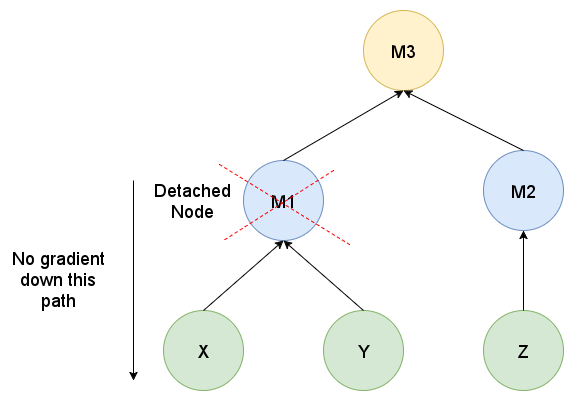

In [0]:
m1 = x + y
m2 = z ** 2
m1 = m1.detach()
m3 = m1 + m2
m3.backward(torch.ones(3, 5))

In [56]:
print('dm3/dx \n\n %s ' % (x.grad))
print('\ndm3/dy \n\n %s ' % (y.grad))
print('\ndm3/dz \n\n %s ' % (z.grad))

dm3/dx 

 None 

dm3/dy 

 None 

dm3/dz 

 tensor([[ 0.5795,  0.8093,  1.7451, -0.9425,  0.1835],
        [-1.4852,  0.4426,  0.8863,  0.2236, -0.4466],
        [ 1.7315,  1.9667, -1.7428,  0.4190,  1.6634]]) 


## Gradients w.r.t intermediate variables in the graph

1. By default, all PyTorch gradient computations w.r.t intermediate nodes in the graph are ad-hoc.

2. This is in the interest of saving memory.

3. To compute gradients w.r.t intermediate variables, use `.retain_grad()` or explicitly compute gradients using `torch.autograd.grad`

4. `.retain_grad()` populates the `.grad` attribute of the Variable while `torch.autograd.grad` returns a Variable that contains the gradients.

In [0]:
x = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_()
y = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_()
z = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_()

In [68]:
m1 = x + y
m2 = z ** 2
m3 = m1 * m2
m3.backward(torch.ones(3, 5))

print('dm3/dm1 \n\n %s ' % (m1.grad))
print('dm3/dm2 \n\n %s ' % (m2.grad))

dm3/dm1 

 None 
dm3/dm2 

 None 


In [69]:
m1 = x + y
m2 = z ** 2
m1.retain_grad()
m2.retain_grad()
m3 = m1 * m2
m3.backward(torch.ones(3, 5))

print('dm3/dm1 \n\n %s ' % (m1.grad))
print('dm3/dm2 \n\n %s ' % (m2.grad))

dm3/dm1 

 tensor([[9.6129e-02, 1.4249e-01, 2.2255e-01, 1.9902e-02, 8.3422e-01],
        [1.6239e-01, 5.9241e-01, 3.4081e-01, 2.7938e-01, 5.3793e-01],
        [3.2842e-01, 1.2551e-04, 5.2016e-01, 1.6277e-01, 8.5518e-01]]) 
dm3/dm2 

 tensor([[ 0.2053, -1.2178, -0.2698,  1.5787,  0.4236],
        [-0.1428, -0.1256,  1.9713,  0.7863, -1.3517],
        [-0.8571, -1.6095,  0.0827, -0.4725, -0.7498]]) 


### In place operations with autograd

source: http://pytorch.org/docs/master/notes/autograd.html

In place operations are suffixed by `_` ex: `log_`, `uniform_` etc.

1. Supporting in-place operations in autograd is difficult and PyTorch discourages their use in most cases.

2. Autograd’s aggressive buffer freeing and reuse makes it very efficient and there are very few occasions when in-place operations actually lower memory usage by any significant amount. Unless you’re operating under heavy memory pressure, you might never need to use them.

### There are two main reasons that limit the applicability of in-place operations:

(a) In-place operations can potentially overwrite values required to compute gradients. Gradient formula of some in-place operations requires the original input (such as `log_`), and while it is possible to recreate it by computing the inverse operation, it is numerically unstable, and requires additional work that often defeats the purpose of using these functions.

(b) Every in-place operation actually requires the implementation to rewrite the computational graph. Out-of-place versions simply allocate new objects and keep references to the old graph, while in-place operations, require changing the creator of all inputs to the Function representing this operation. This can be tricky, especially if there are many Variables that reference the same storage (e.g. created by indexing or transposing), and in-place functions will actually raise an error if the storage of modified inputs is referenced by any other Variable.
In-place correctness checks

## Second and higher order derivatives

### Computing gradients w.r.t gradients

1. `o = xy + z`
2. `l = o + do_dz`

### Practical application of this is gradient penalty (such as WGAN-GP)

In [0]:
x = torch.Tensor(5, 3).uniform_(-1, 1).requires_grad_()
y = torch.Tensor(3, 5).uniform_(-1, 1).requires_grad_()
z = torch.Tensor(5, 5).uniform_(-1, 1).requires_grad_()

In [73]:
o = torch.mm(x, y) + z ** 2
# retain_graph: If False, the graph used to compute the grad will be freed. 
# create_graph: If True, graph of the derivative will be constructed, allowing to compute higher order derivative products.
do_dz = torch.autograd.grad(o, z, grad_outputs=torch.ones(5, 5), retain_graph=False)#, create_graph=True)
print('do/dz \n\n : %s ' % (do_dz[0]))
l = o + do_dz[0]
dl_dz = torch.autograd.grad(l, z, grad_outputs=torch.ones(5, 5))
print('dl/dz \n\n : %s ' % (dl_dz[0]))

do/dz 

 : tensor([[-0.9264,  1.1467, -1.0620,  0.2188,  0.1781],
        [-0.8572,  1.8609,  1.8834, -0.8629, -0.8447],
        [ 1.5545,  0.7153,  1.8596, -0.5513, -0.8332],
        [-1.6531, -0.8170,  1.2350, -0.8091,  0.4654],
        [-1.7014,  1.9977, -0.9953, -0.7483,  0.6049]]) 


RuntimeError: ignored

In [0]:
n = 16
X = torch.rand(n, 4, requires_grad=True)
t = torch.randn(n, 1)
W = torch.randn(4, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
alpha = 0.1
# Q: compute dl_dw where 
#    l = average loss(f(x), t) + ||f'(x)||^2
#    loss: squared loss
#    f(x) = x*W + b
